**References:**

https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Environment Setup**

**Importing relevant Pytorch modules**

In [ ]:
# Importing Libraries
import os
import copy
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


**Setting up Transformations for training and test data**

In [ ]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

**Setting up class to download CIFAR10 data**

In [ ]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


Downloading CIFAR10 data and creating train, test, valid loaders:

In [ ]:
cdata = GetCIFAR10_TrainData(os.chdir(".."))
trainset = cdata.download_train_data()
testset = cdata.download_test_data()

VALID_RATIO = 0.9
n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(trainset), len(validset), len(testset)

(45000, 5000, 10000)

In [ ]:
BATCH_SIZE = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# **ResNet Model Setup**

In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

Setting up a ResNet model with following architecture:

**image(32x32x3) -> conv2d(3,64) -> BN(64) -> ReLU -> ResLayer(3, 64,\1) -> ResLayer(3, 128, \2) -> ResLayer(3, 256, \2) -> AVGPool2d(4) -> FC -> Softmax**

where **ResLayer(B, C, S)** represents a residual layer with #B blocks, #C channels in each network layer and a stride of #S at the first block of the residual layer.

In [ ]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.1)
        
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        # out = self.dropout1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.dropout2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        self.conv = conv3x3(in_channels=3, out_channels=64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block=block, out_channels=64, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block=block, out_channels=128, blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block=block, out_channels=256, blocks=layers[2], stride=2)
        # self.layer4 = self.make_layer(block=block, out_channels=512, blocks=layers[3], stride=2)

        self.avg_pool = nn.AvgPool2d(4)
        # self.fc = nn.Linear(256, num_classes)
        self.fc = nn.Linear(1024, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    # return ResNet(ResidualBlock, [2, 2, 2, 2])
    return ResNet(ResidualBlock, [3, 3, 3])

In [ ]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    ResidualBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

# **Training and Testing the model**

Defining the training, testing and evaluation functions for model:

In [ ]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        # train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        # print statistics
        
        running_loss += loss.item()
        pbar.set_description(desc=f'Batch_id={batch_idx} Batch Loss={loss.item()} Running Loss={running_loss} Running Accuracy={100*correct/processed:0.2f}')
        # train_acc.append(100*correct/processed)
    
    train_losses.append(running_loss)
    train_acc.append(100*correct/processed)

In [ ]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified, correct / len(test_dataloader.dataset)

In [ ]:
def model_evaluation(model, device, loader):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = F.nll_loss(y_pred, y)
        
            pred = y_pred.argmax(dim=1, keepdim=True)
            acc = pred.eq(y.view_as(pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    epoch_loss / len(loader.dataset), epoch_acc, len(loader.dataset),
    100. * epoch_acc / len(loader.dataset)))

    return epoch_loss, epoch_acc / len(loader.dataset)

Setting up training parameters:

In [ ]:
# Defining parameters

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

A custom function to save the results to a csv file:

In [ ]:
import pandas

def save_to_csv(csvname, train_losses, train_accs, test_losses, test_accs):
  df = pandas.DataFrame()
  df["epoch"] = [i+1 for i in range(len(train_losses))]
  df["train_loss"] = train_losses
  df["test_loss"] = test_losses
  df["train_acc"] = train_accs
  df["test_acc"] = test_accs
  df.to_csv(csvname)

Actual training of the model below for 120 epochs:

In [ ]:
# Training the model

train_acc = []
train_losses = []
valid_accs = []
valid_losses = []
test_acc = []
test_losses = []
min_valid_loss = None
max_acc = None

EPOCHS = 120

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)

    # Validating the model for the current epoch
    valid_loss, valid_acc = model_evaluation(model, device, validloader)  

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if not min_valid_loss:
      min_valid_loss = valid_loss
    else:
      if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model, "best_model.pickle")

    scheduler.step(train_losses[-1])
    # scheduler.step(valid_loss)

    misclassified, test_acc2 = model_testing(model, device, testloader, test_acc, test_losses)

    if not max_acc:
      max_acc = test_acc2
    else:
      if test_acc2 > max_acc:
        max_acc = test_acc2
        torch.save(model, "best_test_acc_model.pickle")

    save_to_csv("7_resnet_3_3_3_inchannels_64.csv", train_losses, train_acc, test_losses, test_acc)


EPOCHS : 0


Batch_id=87 Batch Loss=1.262488603591919 Running Loss=141.1420066356659 Running Accuracy=41.04: 100%|██████████| 88/88 [00:45<00:00,  1.92it/s]



Validation set: Average loss: 0.0024, Accuracy: 2778/5000 (55.56%)


Test set: Average loss: 1.2244, Accuracy: 5589/10000 (55.89%)

EPOCHS : 1


Batch_id=87 Batch Loss=1.0726550817489624 Running Loss=101.9153596162796 Running Accuracy=58.55: 100%|██████████| 88/88 [00:48<00:00,  1.83it/s]



Validation set: Average loss: 0.0019, Accuracy: 3249/5000 (64.98%)


Test set: Average loss: 0.9869, Accuracy: 6503/10000 (65.03%)

EPOCHS : 2


Batch_id=87 Batch Loss=0.8720034956932068 Running Loss=80.9749630689621 Running Accuracy=67.40: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]



Validation set: Average loss: 0.0020, Accuracy: 3345/5000 (66.90%)


Test set: Average loss: 1.0062, Accuracy: 6685/10000 (66.85%)

EPOCHS : 3


Batch_id=87 Batch Loss=0.7858197689056396 Running Loss=70.04632449150085 Running Accuracy=71.88: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0015, Accuracy: 3649/5000 (72.98%)


Test set: Average loss: 0.7582, Accuracy: 7351/10000 (73.51%)

EPOCHS : 4


Batch_id=87 Batch Loss=0.7516804933547974 Running Loss=62.39293998479843 Running Accuracy=75.04: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0014, Accuracy: 3735/5000 (74.70%)


Test set: Average loss: 0.7325, Accuracy: 7476/10000 (74.76%)

EPOCHS : 5


Batch_id=87 Batch Loss=0.6002146601676941 Running Loss=55.428797006607056 Running Accuracy=77.93: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0014, Accuracy: 3838/5000 (76.76%)


Test set: Average loss: 0.6965, Accuracy: 7620/10000 (76.20%)

EPOCHS : 6


Batch_id=87 Batch Loss=0.5237283110618591 Running Loss=51.98232200741768 Running Accuracy=79.40: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]



Validation set: Average loss: 0.0013, Accuracy: 3946/5000 (78.92%)


Test set: Average loss: 0.6343, Accuracy: 7900/10000 (79.00%)

EPOCHS : 7


Batch_id=87 Batch Loss=0.5205262899398804 Running Loss=47.89754042029381 Running Accuracy=80.95: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0012, Accuracy: 4025/5000 (80.50%)


Test set: Average loss: 0.6064, Accuracy: 7964/10000 (79.64%)

EPOCHS : 8


Batch_id=87 Batch Loss=0.5216915607452393 Running Loss=44.203804552555084 Running Accuracy=82.50: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0011, Accuracy: 4082/5000 (81.64%)


Test set: Average loss: 0.5531, Accuracy: 8131/10000 (81.31%)

EPOCHS : 9


Batch_id=87 Batch Loss=0.5858139395713806 Running Loss=42.14230865240097 Running Accuracy=83.24: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0010, Accuracy: 4164/5000 (83.28%)


Test set: Average loss: 0.5237, Accuracy: 8237/10000 (82.37%)

EPOCHS : 10


Batch_id=87 Batch Loss=0.40738728642463684 Running Loss=38.68060812354088 Running Accuracy=84.62: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0011, Accuracy: 4144/5000 (82.88%)


Test set: Average loss: 0.5709, Accuracy: 8145/10000 (81.45%)

EPOCHS : 11


Batch_id=87 Batch Loss=0.47860410809516907 Running Loss=36.736238688230515 Running Accuracy=85.43: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]



Validation set: Average loss: 0.0010, Accuracy: 4163/5000 (83.26%)


Test set: Average loss: 0.5342, Accuracy: 8229/10000 (82.29%)

EPOCHS : 12


Batch_id=87 Batch Loss=0.44320499897003174 Running Loss=34.83720925450325 Running Accuracy=86.13: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0009, Accuracy: 4260/5000 (85.20%)


Test set: Average loss: 0.4787, Accuracy: 8429/10000 (84.29%)

EPOCHS : 13


Batch_id=87 Batch Loss=0.3658885359764099 Running Loss=32.78047031164169 Running Accuracy=86.98: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0009, Accuracy: 4270/5000 (85.40%)


Test set: Average loss: 0.4742, Accuracy: 8434/10000 (84.34%)

EPOCHS : 14


Batch_id=87 Batch Loss=0.4049336612224579 Running Loss=31.499076664447784 Running Accuracy=87.50: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0010, Accuracy: 4182/5000 (83.64%)


Test set: Average loss: 0.5220, Accuracy: 8268/10000 (82.68%)

EPOCHS : 15


Batch_id=87 Batch Loss=0.34010306000709534 Running Loss=29.987320229411125 Running Accuracy=87.95: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0009, Accuracy: 4262/5000 (85.24%)


Test set: Average loss: 0.4665, Accuracy: 8447/10000 (84.47%)

EPOCHS : 16


Batch_id=87 Batch Loss=0.44092392921447754 Running Loss=29.80385749042034 Running Accuracy=87.97: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4372/5000 (87.44%)


Test set: Average loss: 0.3966, Accuracy: 8642/10000 (86.42%)

EPOCHS : 17


Batch_id=87 Batch Loss=0.35640284419059753 Running Loss=27.47373028099537 Running Accuracy=88.86: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0011, Accuracy: 4165/5000 (83.30%)


Test set: Average loss: 0.6028, Accuracy: 8150/10000 (81.50%)

EPOCHS : 18


Batch_id=87 Batch Loss=0.2603803277015686 Running Loss=26.90084983408451 Running Accuracy=89.15: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]



Validation set: Average loss: 0.0009, Accuracy: 4302/5000 (86.04%)


Test set: Average loss: 0.4611, Accuracy: 8528/10000 (85.28%)

EPOCHS : 19


Batch_id=87 Batch Loss=0.27755120396614075 Running Loss=24.56327474117279 Running Accuracy=90.29: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4362/5000 (87.24%)


Test set: Average loss: 0.4124, Accuracy: 8683/10000 (86.83%)

EPOCHS : 20


Batch_id=87 Batch Loss=0.2340584099292755 Running Loss=24.367297932505608 Running Accuracy=89.98: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0009, Accuracy: 4342/5000 (86.84%)


Test set: Average loss: 0.4856, Accuracy: 8552/10000 (85.52%)

EPOCHS : 21


Batch_id=87 Batch Loss=0.2914449870586395 Running Loss=23.380609467625618 Running Accuracy=90.62: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0010, Accuracy: 4234/5000 (84.68%)


Test set: Average loss: 0.5454, Accuracy: 8389/10000 (83.89%)

EPOCHS : 22


Batch_id=87 Batch Loss=0.2908276617527008 Running Loss=22.42023177444935 Running Accuracy=90.98: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0009, Accuracy: 4265/5000 (85.30%)


Test set: Average loss: 0.4745, Accuracy: 8503/10000 (85.03%)

EPOCHS : 23


Batch_id=87 Batch Loss=0.24841555953025818 Running Loss=21.257915437221527 Running Accuracy=91.37: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0009, Accuracy: 4338/5000 (86.76%)


Test set: Average loss: 0.4838, Accuracy: 8570/10000 (85.70%)

EPOCHS : 24


Batch_id=87 Batch Loss=0.18569272756576538 Running Loss=19.53533060848713 Running Accuracy=92.16: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4457/5000 (89.14%)


Test set: Average loss: 0.3676, Accuracy: 8830/10000 (88.30%)

EPOCHS : 25


Batch_id=87 Batch Loss=0.2288569062948227 Running Loss=19.25261825323105 Running Accuracy=92.05: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4354/5000 (87.08%)


Test set: Average loss: 0.4160, Accuracy: 8655/10000 (86.55%)

EPOCHS : 26


Batch_id=87 Batch Loss=0.19877810776233673 Running Loss=19.209897503256798 Running Accuracy=92.18: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4429/5000 (88.58%)


Test set: Average loss: 0.4114, Accuracy: 8734/10000 (87.34%)

EPOCHS : 27


Batch_id=87 Batch Loss=0.2343948930501938 Running Loss=18.11800779402256 Running Accuracy=92.74: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0008, Accuracy: 4371/5000 (87.42%)


Test set: Average loss: 0.4271, Accuracy: 8704/10000 (87.04%)

EPOCHS : 28


Batch_id=87 Batch Loss=0.21348538994789124 Running Loss=18.34556709229946 Running Accuracy=92.58: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0010, Accuracy: 4272/5000 (85.44%)


Test set: Average loss: 0.5288, Accuracy: 8475/10000 (84.75%)

EPOCHS : 29


Batch_id=87 Batch Loss=0.21392729878425598 Running Loss=16.942116528749466 Running Accuracy=93.24: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]



Validation set: Average loss: 0.0007, Accuracy: 4472/5000 (89.44%)


Test set: Average loss: 0.3670, Accuracy: 8885/10000 (88.85%)

EPOCHS : 30


Batch_id=87 Batch Loss=0.18314862251281738 Running Loss=16.596511885523796 Running Accuracy=93.20: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4492/5000 (89.84%)


Test set: Average loss: 0.3740, Accuracy: 8873/10000 (88.73%)

EPOCHS : 31


Batch_id=87 Batch Loss=0.23115889728069305 Running Loss=15.644188344478607 Running Accuracy=93.66: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4448/5000 (88.96%)


Test set: Average loss: 0.4173, Accuracy: 8768/10000 (87.68%)

EPOCHS : 32


Batch_id=87 Batch Loss=0.15904907882213593 Running Loss=15.145393952727318 Running Accuracy=93.87: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0008, Accuracy: 4446/5000 (88.92%)


Test set: Average loss: 0.3959, Accuracy: 8830/10000 (88.30%)

EPOCHS : 33


Batch_id=87 Batch Loss=0.18872897326946259 Running Loss=15.50084737688303 Running Accuracy=93.68: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4448/5000 (88.96%)


Test set: Average loss: 0.4097, Accuracy: 8808/10000 (88.08%)

EPOCHS : 34


Batch_id=87 Batch Loss=0.18007834255695343 Running Loss=14.06361037492752 Running Accuracy=94.36: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0009, Accuracy: 4373/5000 (87.46%)


Test set: Average loss: 0.4590, Accuracy: 8682/10000 (86.82%)

EPOCHS : 35


Batch_id=87 Batch Loss=0.1768741011619568 Running Loss=13.70895004272461 Running Accuracy=94.57: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0008, Accuracy: 4441/5000 (88.82%)


Test set: Average loss: 0.4268, Accuracy: 8760/10000 (87.60%)

EPOCHS : 36


Batch_id=87 Batch Loss=0.17246316373348236 Running Loss=12.42824324220419 Running Accuracy=95.03: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0008, Accuracy: 4417/5000 (88.34%)


Test set: Average loss: 0.4672, Accuracy: 8718/10000 (87.18%)

EPOCHS : 37


Batch_id=87 Batch Loss=0.14267753064632416 Running Loss=13.317420780658722 Running Accuracy=94.55: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4480/5000 (89.60%)


Test set: Average loss: 0.4039, Accuracy: 8833/10000 (88.33%)

EPOCHS : 38


Batch_id=87 Batch Loss=0.16040880978107452 Running Loss=11.98531986027956 Running Accuracy=95.10: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4427/5000 (88.54%)


Test set: Average loss: 0.4210, Accuracy: 8807/10000 (88.07%)

EPOCHS : 39


Batch_id=87 Batch Loss=0.15558366477489471 Running Loss=11.982018023729324 Running Accuracy=95.06: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4532/5000 (90.64%)


Test set: Average loss: 0.3753, Accuracy: 8887/10000 (88.87%)

EPOCHS : 40


Batch_id=87 Batch Loss=0.12339391559362411 Running Loss=11.166795641183853 Running Accuracy=95.47: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4503/5000 (90.06%)


Test set: Average loss: 0.3813, Accuracy: 8895/10000 (88.95%)

EPOCHS : 41


Batch_id=87 Batch Loss=0.12732313573360443 Running Loss=11.117793343961239 Running Accuracy=95.51: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0009, Accuracy: 4401/5000 (88.02%)


Test set: Average loss: 0.4937, Accuracy: 8704/10000 (87.04%)

EPOCHS : 42


Batch_id=87 Batch Loss=0.13405326008796692 Running Loss=11.186390683054924 Running Accuracy=95.53: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4494/5000 (89.88%)


Test set: Average loss: 0.3834, Accuracy: 8926/10000 (89.26%)

EPOCHS : 43


Batch_id=87 Batch Loss=0.15162400901317596 Running Loss=10.316328540444374 Running Accuracy=95.84: 100%|██████████| 88/88 [00:51<00:00,  1.73it/s]



Validation set: Average loss: 0.0009, Accuracy: 4388/5000 (87.76%)


Test set: Average loss: 0.4880, Accuracy: 8698/10000 (86.98%)

EPOCHS : 44


Batch_id=87 Batch Loss=0.11958140879869461 Running Loss=10.685552686452866 Running Accuracy=95.60: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4546/5000 (90.92%)


Test set: Average loss: 0.3493, Accuracy: 9006/10000 (90.06%)

EPOCHS : 45


Batch_id=87 Batch Loss=0.10709282755851746 Running Loss=9.99150064587593 Running Accuracy=95.93: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4511/5000 (90.22%)


Test set: Average loss: 0.3957, Accuracy: 8915/10000 (89.15%)

EPOCHS : 46


Batch_id=87 Batch Loss=0.12594452500343323 Running Loss=9.70086968690157 Running Accuracy=96.07: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0008, Accuracy: 4483/5000 (89.66%)


Test set: Average loss: 0.4393, Accuracy: 8820/10000 (88.20%)

EPOCHS : 47


Batch_id=87 Batch Loss=0.10352640599012375 Running Loss=9.19004662334919 Running Accuracy=96.31: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4542/5000 (90.84%)


Test set: Average loss: 0.3742, Accuracy: 8968/10000 (89.68%)

EPOCHS : 48


Batch_id=87 Batch Loss=0.09583024680614471 Running Loss=8.521202094852924 Running Accuracy=96.57: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4541/5000 (90.82%)


Test set: Average loss: 0.3629, Accuracy: 9019/10000 (90.19%)

EPOCHS : 49


Batch_id=87 Batch Loss=0.10713282227516174 Running Loss=8.899960529059172 Running Accuracy=96.34: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0010, Accuracy: 4416/5000 (88.32%)


Test set: Average loss: 0.5177, Accuracy: 8738/10000 (87.38%)

EPOCHS : 50


Batch_id=87 Batch Loss=0.11882347613573074 Running Loss=8.377012893557549 Running Accuracy=96.66: 100%|██████████| 88/88 [00:51<00:00,  1.73it/s]



Validation set: Average loss: 0.0010, Accuracy: 4381/5000 (87.62%)


Test set: Average loss: 0.5554, Accuracy: 8648/10000 (86.48%)

EPOCHS : 51


Batch_id=87 Batch Loss=0.12556321918964386 Running Loss=8.086539052426815 Running Accuracy=96.80: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0008, Accuracy: 4485/5000 (89.70%)


Test set: Average loss: 0.4125, Accuracy: 8876/10000 (88.76%)

EPOCHS : 52


Batch_id=87 Batch Loss=0.08906057476997375 Running Loss=7.956979367882013 Running Accuracy=96.77: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4483/5000 (89.66%)


Test set: Average loss: 0.4265, Accuracy: 8863/10000 (88.63%)

EPOCHS : 53


Batch_id=87 Batch Loss=0.06308408081531525 Running Loss=7.815103832632303 Running Accuracy=96.79: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4532/5000 (90.64%)


Test set: Average loss: 0.4020, Accuracy: 8941/10000 (89.41%)

EPOCHS : 54


Batch_id=87 Batch Loss=0.07224598526954651 Running Loss=7.429205909371376 Running Accuracy=97.05: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0009, Accuracy: 4474/5000 (89.48%)


Test set: Average loss: 0.4682, Accuracy: 8815/10000 (88.15%)

EPOCHS : 55


Batch_id=87 Batch Loss=0.10542085021734238 Running Loss=7.545476775616407 Running Accuracy=96.97: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4566/5000 (91.32%)


Test set: Average loss: 0.3770, Accuracy: 8998/10000 (89.98%)

EPOCHS : 56


Batch_id=87 Batch Loss=0.0789194330573082 Running Loss=6.8021779134869576 Running Accuracy=97.25: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4506/5000 (90.12%)


Test set: Average loss: 0.4085, Accuracy: 8958/10000 (89.58%)

EPOCHS : 57


Batch_id=87 Batch Loss=0.07563657313585281 Running Loss=6.793327126652002 Running Accuracy=97.37: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4507/5000 (90.14%)


Test set: Average loss: 0.4325, Accuracy: 8925/10000 (89.25%)

EPOCHS : 58


Batch_id=87 Batch Loss=0.06873393803834915 Running Loss=6.50728627294302 Running Accuracy=97.33: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4520/5000 (90.40%)


Test set: Average loss: 0.4228, Accuracy: 8940/10000 (89.40%)

EPOCHS : 59


Batch_id=87 Batch Loss=0.06404850631952286 Running Loss=6.978892266750336 Running Accuracy=97.23: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4550/5000 (91.00%)


Test set: Average loss: 0.3680, Accuracy: 9030/10000 (90.30%)

EPOCHS : 60


Batch_id=87 Batch Loss=0.06549987196922302 Running Loss=6.614367242902517 Running Accuracy=97.38: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4584/5000 (91.68%)


Test set: Average loss: 0.3697, Accuracy: 9023/10000 (90.23%)

EPOCHS : 61


Batch_id=87 Batch Loss=0.07905779033899307 Running Loss=6.381767079234123 Running Accuracy=97.48: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4549/5000 (90.98%)


Test set: Average loss: 0.3864, Accuracy: 8989/10000 (89.89%)

EPOCHS : 62


Batch_id=87 Batch Loss=0.07246455550193787 Running Loss=5.684018604457378 Running Accuracy=97.77: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4576/5000 (91.52%)


Test set: Average loss: 0.3683, Accuracy: 9052/10000 (90.52%)

EPOCHS : 63


Batch_id=87 Batch Loss=0.0739167332649231 Running Loss=5.8464076500386 Running Accuracy=97.60: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4559/5000 (91.18%)


Test set: Average loss: 0.3852, Accuracy: 9016/10000 (90.16%)

EPOCHS : 64


Batch_id=87 Batch Loss=0.07834681123495102 Running Loss=5.473581463098526 Running Accuracy=97.85: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4568/5000 (91.36%)


Test set: Average loss: 0.3913, Accuracy: 9012/10000 (90.12%)

EPOCHS : 65


Batch_id=87 Batch Loss=0.07738609611988068 Running Loss=5.9511612467467785 Running Accuracy=97.62: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0009, Accuracy: 4469/5000 (89.38%)


Test set: Average loss: 0.4489, Accuracy: 8962/10000 (89.62%)

EPOCHS : 66


Batch_id=87 Batch Loss=0.0734136626124382 Running Loss=6.094253391027451 Running Accuracy=97.52: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4556/5000 (91.12%)


Test set: Average loss: 0.3695, Accuracy: 9066/10000 (90.66%)

EPOCHS : 67


Batch_id=87 Batch Loss=0.04748709499835968 Running Loss=5.523536624386907 Running Accuracy=97.81: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4578/5000 (91.56%)

Epoch 00068: reducing learning rate of group 0 to 1.0000e-03.

Test set: Average loss: 0.3742, Accuracy: 9082/10000 (90.82%)

EPOCHS : 68


Batch_id=87 Batch Loss=0.04335090517997742 Running Loss=3.51616258174181 Running Accuracy=98.68: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4637/5000 (92.74%)


Test set: Average loss: 0.3099, Accuracy: 9191/10000 (91.91%)

EPOCHS : 69


Batch_id=87 Batch Loss=0.023274581879377365 Running Loss=2.5749496519565582 Running Accuracy=99.09: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4644/5000 (92.88%)


Test set: Average loss: 0.3091, Accuracy: 9192/10000 (91.92%)

EPOCHS : 70


Batch_id=87 Batch Loss=0.015302213840186596 Running Loss=2.340180260129273 Running Accuracy=99.18: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4640/5000 (92.80%)


Test set: Average loss: 0.3098, Accuracy: 9200/10000 (92.00%)

EPOCHS : 71


Batch_id=87 Batch Loss=0.03387013450264931 Running Loss=2.2089338498190045 Running Accuracy=99.25: 100%|██████████| 88/88 [00:51<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4649/5000 (92.98%)


Test set: Average loss: 0.3073, Accuracy: 9201/10000 (92.01%)

EPOCHS : 72


Batch_id=87 Batch Loss=0.0297563374042511 Running Loss=2.1390708992257714 Running Accuracy=99.28: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4641/5000 (92.82%)


Test set: Average loss: 0.3052, Accuracy: 9203/10000 (92.03%)

EPOCHS : 73


Batch_id=87 Batch Loss=0.012075817212462425 Running Loss=1.974735734052956 Running Accuracy=99.32: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4651/5000 (93.02%)


Test set: Average loss: 0.3043, Accuracy: 9217/10000 (92.17%)

EPOCHS : 74


Batch_id=87 Batch Loss=0.022427663207054138 Running Loss=1.9562421701848507 Running Accuracy=99.40: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4647/5000 (92.94%)


Test set: Average loss: 0.3080, Accuracy: 9202/10000 (92.02%)

EPOCHS : 75


Batch_id=87 Batch Loss=0.01170472800731659 Running Loss=1.8892022343352437 Running Accuracy=99.40: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4655/5000 (93.10%)


Test set: Average loss: 0.3054, Accuracy: 9214/10000 (92.14%)

EPOCHS : 76


Batch_id=87 Batch Loss=0.016812428832054138 Running Loss=1.751364384777844 Running Accuracy=99.45: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4656/5000 (93.12%)


Test set: Average loss: 0.3086, Accuracy: 9187/10000 (91.87%)

EPOCHS : 77


Batch_id=87 Batch Loss=0.031483229249715805 Running Loss=1.8178084306418896 Running Accuracy=99.40: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4654/5000 (93.08%)


Test set: Average loss: 0.3037, Accuracy: 9209/10000 (92.09%)

EPOCHS : 78


Batch_id=87 Batch Loss=0.012975377030670643 Running Loss=1.7052508634515107 Running Accuracy=99.46: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4659/5000 (93.18%)


Test set: Average loss: 0.3051, Accuracy: 9205/10000 (92.05%)

EPOCHS : 79


Batch_id=87 Batch Loss=0.01809760369360447 Running Loss=1.6745556332170963 Running Accuracy=99.49: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]



Validation set: Average loss: 0.0006, Accuracy: 4660/5000 (93.20%)


Test set: Average loss: 0.3041, Accuracy: 9217/10000 (92.17%)

EPOCHS : 80


Batch_id=87 Batch Loss=0.014194831252098083 Running Loss=1.589416962582618 Running Accuracy=99.52: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4660/5000 (93.20%)


Test set: Average loss: 0.3057, Accuracy: 9205/10000 (92.05%)

EPOCHS : 81


Batch_id=87 Batch Loss=0.017852557823061943 Running Loss=1.6283006370067596 Running Accuracy=99.50: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4656/5000 (93.12%)


Test set: Average loss: 0.3058, Accuracy: 9201/10000 (92.01%)

EPOCHS : 82


Batch_id=87 Batch Loss=0.01767949014902115 Running Loss=1.6420785156078637 Running Accuracy=99.46: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4651/5000 (93.02%)


Test set: Average loss: 0.3068, Accuracy: 9216/10000 (92.16%)

EPOCHS : 83


Batch_id=87 Batch Loss=0.02357329986989498 Running Loss=1.5492067374289036 Running Accuracy=99.54: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4649/5000 (92.98%)


Test set: Average loss: 0.3066, Accuracy: 9218/10000 (92.18%)

EPOCHS : 84


Batch_id=87 Batch Loss=0.035407647490501404 Running Loss=1.545086171478033 Running Accuracy=99.52: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4652/5000 (93.04%)


Test set: Average loss: 0.3119, Accuracy: 9194/10000 (91.94%)

EPOCHS : 85


Batch_id=87 Batch Loss=0.0051263137720525265 Running Loss=1.599287565331906 Running Accuracy=99.47: 100%|██████████| 88/88 [00:51<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4660/5000 (93.20%)


Test set: Average loss: 0.3104, Accuracy: 9202/10000 (92.02%)

EPOCHS : 86


Batch_id=87 Batch Loss=0.02638264000415802 Running Loss=1.487869756296277 Running Accuracy=99.54: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4654/5000 (93.08%)


Test set: Average loss: 0.3087, Accuracy: 9200/10000 (92.00%)

EPOCHS : 87


Batch_id=87 Batch Loss=0.015175233595073223 Running Loss=1.453072430100292 Running Accuracy=99.54: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4654/5000 (93.08%)


Test set: Average loss: 0.3067, Accuracy: 9222/10000 (92.22%)

EPOCHS : 88


Batch_id=87 Batch Loss=0.011921381577849388 Running Loss=1.428811022080481 Running Accuracy=99.55: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4657/5000 (93.14%)


Test set: Average loss: 0.3049, Accuracy: 9213/10000 (92.13%)

EPOCHS : 89


Batch_id=87 Batch Loss=0.022046513855457306 Running Loss=1.4056488941423595 Running Accuracy=99.54: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4653/5000 (93.06%)


Test set: Average loss: 0.3097, Accuracy: 9210/10000 (92.10%)

EPOCHS : 90


Batch_id=87 Batch Loss=0.016708580777049065 Running Loss=1.4276341116055846 Running Accuracy=99.58: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4661/5000 (93.22%)


Test set: Average loss: 0.3105, Accuracy: 9204/10000 (92.04%)

EPOCHS : 91


Batch_id=87 Batch Loss=0.009804191999137402 Running Loss=1.4041921142488718 Running Accuracy=99.55: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4662/5000 (93.24%)


Test set: Average loss: 0.3124, Accuracy: 9218/10000 (92.18%)

EPOCHS : 92


Batch_id=87 Batch Loss=0.011537907645106316 Running Loss=1.3754651765339077 Running Accuracy=99.55: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4653/5000 (93.06%)


Test set: Average loss: 0.3099, Accuracy: 9215/10000 (92.15%)

EPOCHS : 93


Batch_id=87 Batch Loss=0.015652483329176903 Running Loss=1.436702510342002 Running Accuracy=99.55: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4665/5000 (93.30%)


Test set: Average loss: 0.3086, Accuracy: 9225/10000 (92.25%)

EPOCHS : 94


Batch_id=87 Batch Loss=0.015769511461257935 Running Loss=1.3660717098973691 Running Accuracy=99.59: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4655/5000 (93.10%)


Test set: Average loss: 0.3072, Accuracy: 9221/10000 (92.21%)

EPOCHS : 95


Batch_id=87 Batch Loss=0.01085734087973833 Running Loss=1.3309774734079838 Running Accuracy=99.61: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4644/5000 (92.88%)


Test set: Average loss: 0.3097, Accuracy: 9228/10000 (92.28%)

EPOCHS : 96


Batch_id=87 Batch Loss=0.01759844273328781 Running Loss=1.2143539595417678 Running Accuracy=99.64: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4651/5000 (93.02%)


Test set: Average loss: 0.3092, Accuracy: 9216/10000 (92.16%)

EPOCHS : 97


Batch_id=87 Batch Loss=0.012883779592812061 Running Loss=1.2937035565264523 Running Accuracy=99.64: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4655/5000 (93.10%)


Test set: Average loss: 0.3116, Accuracy: 9215/10000 (92.15%)

EPOCHS : 98


Batch_id=87 Batch Loss=0.013217363506555557 Running Loss=1.307971395086497 Running Accuracy=99.59: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4655/5000 (93.10%)


Test set: Average loss: 0.3115, Accuracy: 9199/10000 (91.99%)

EPOCHS : 99


Batch_id=87 Batch Loss=0.023650983348488808 Running Loss=1.2352194120176136 Running Accuracy=99.61: 100%|██████████| 88/88 [00:51<00:00,  1.70it/s]



Validation set: Average loss: 0.0006, Accuracy: 4651/5000 (93.02%)

Epoch 00100: reducing learning rate of group 0 to 1.0000e-04.

Test set: Average loss: 0.3108, Accuracy: 9222/10000 (92.22%)

EPOCHS : 100


Batch_id=87 Batch Loss=0.008369969204068184 Running Loss=1.3425367111340165 Running Accuracy=99.59: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4645/5000 (92.90%)


Test set: Average loss: 0.3113, Accuracy: 9214/10000 (92.14%)

EPOCHS : 101


Batch_id=87 Batch Loss=0.013975811190903187 Running Loss=1.3115625544451177 Running Accuracy=99.59: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4646/5000 (92.92%)


Test set: Average loss: 0.3096, Accuracy: 9220/10000 (92.20%)

EPOCHS : 102


Batch_id=87 Batch Loss=0.013185541145503521 Running Loss=1.2581335506401956 Running Accuracy=99.59: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4650/5000 (93.00%)

Epoch 00103: reducing learning rate of group 0 to 1.0000e-05.

Test set: Average loss: 0.3101, Accuracy: 9224/10000 (92.24%)

EPOCHS : 103


Batch_id=87 Batch Loss=0.013212385587394238 Running Loss=1.1558271197136492 Running Accuracy=99.67: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4648/5000 (92.96%)


Test set: Average loss: 0.3104, Accuracy: 9219/10000 (92.19%)

EPOCHS : 104


Batch_id=87 Batch Loss=0.011204209178686142 Running Loss=1.1443282319232821 Running Accuracy=99.67: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4648/5000 (92.96%)


Test set: Average loss: 0.3104, Accuracy: 9216/10000 (92.16%)

EPOCHS : 105


Batch_id=87 Batch Loss=0.020141582936048508 Running Loss=1.2111105201765895 Running Accuracy=99.64: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4652/5000 (93.04%)


Test set: Average loss: 0.3105, Accuracy: 9214/10000 (92.14%)

EPOCHS : 106


Batch_id=87 Batch Loss=0.009277258068323135 Running Loss=1.2775688986293972 Running Accuracy=99.61: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4651/5000 (93.02%)


Test set: Average loss: 0.3101, Accuracy: 9218/10000 (92.18%)

EPOCHS : 107


Batch_id=87 Batch Loss=0.018967460840940475 Running Loss=1.2711509955115616 Running Accuracy=99.59: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4651/5000 (93.02%)

Epoch 00108: reducing learning rate of group 0 to 1.0000e-06.

Test set: Average loss: 0.3104, Accuracy: 9214/10000 (92.14%)

EPOCHS : 108


Batch_id=87 Batch Loss=0.007335425820201635 Running Loss=1.2566345655359328 Running Accuracy=99.58: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4651/5000 (93.02%)


Test set: Average loss: 0.3088, Accuracy: 9224/10000 (92.24%)

EPOCHS : 109


Batch_id=87 Batch Loss=0.020264452323317528 Running Loss=1.2660582982935011 Running Accuracy=99.60: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4649/5000 (92.98%)


Test set: Average loss: 0.3106, Accuracy: 9220/10000 (92.20%)

EPOCHS : 110


Batch_id=87 Batch Loss=0.006861915811896324 Running Loss=1.2275494448840618 Running Accuracy=99.60: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]



Validation set: Average loss: 0.0006, Accuracy: 4653/5000 (93.06%)

Epoch 00111: reducing learning rate of group 0 to 1.0000e-07.

Test set: Average loss: 0.3103, Accuracy: 9220/10000 (92.20%)

EPOCHS : 111


Batch_id=87 Batch Loss=0.008694568648934364 Running Loss=1.154343191999942 Running Accuracy=99.66: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]



Validation set: Average loss: 0.0006, Accuracy: 4647/5000 (92.94%)


Test set: Average loss: 0.3110, Accuracy: 9220/10000 (92.20%)

EPOCHS : 112


Batch_id=87 Batch Loss=0.01036987267434597 Running Loss=1.1717910771258175 Running Accuracy=99.66: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4651/5000 (93.02%)


Test set: Average loss: 0.3094, Accuracy: 9221/10000 (92.21%)

EPOCHS : 113


Batch_id=87 Batch Loss=0.009412938728928566 Running Loss=1.324929642956704 Running Accuracy=99.58: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4648/5000 (92.96%)

Epoch 00114: reducing learning rate of group 0 to 1.0000e-08.

Test set: Average loss: 0.3109, Accuracy: 9219/10000 (92.19%)

EPOCHS : 114


Batch_id=87 Batch Loss=0.02014853060245514 Running Loss=1.2564905351027846 Running Accuracy=99.56: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4649/5000 (92.98%)


Test set: Average loss: 0.3100, Accuracy: 9219/10000 (92.19%)

EPOCHS : 115


Batch_id=87 Batch Loss=0.01789652183651924 Running Loss=1.24852827610448 Running Accuracy=99.62: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4648/5000 (92.96%)


Test set: Average loss: 0.3101, Accuracy: 9225/10000 (92.25%)

EPOCHS : 116


Batch_id=87 Batch Loss=0.015344732441008091 Running Loss=1.182471286971122 Running Accuracy=99.65: 100%|██████████| 88/88 [00:51<00:00,  1.70it/s]



Validation set: Average loss: 0.0006, Accuracy: 4650/5000 (93.00%)


Test set: Average loss: 0.3108, Accuracy: 9225/10000 (92.25%)

EPOCHS : 117


Batch_id=87 Batch Loss=0.016908379271626472 Running Loss=1.2507024556398392 Running Accuracy=99.61: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]



Validation set: Average loss: 0.0006, Accuracy: 4652/5000 (93.04%)


Test set: Average loss: 0.3092, Accuracy: 9224/10000 (92.24%)

EPOCHS : 118


Batch_id=87 Batch Loss=0.010430908761918545 Running Loss=1.220854586455971 Running Accuracy=99.62: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4651/5000 (93.02%)


Test set: Average loss: 0.3099, Accuracy: 9218/10000 (92.18%)

EPOCHS : 119


Batch_id=87 Batch Loss=0.028005326166749 Running Loss=1.186634311452508 Running Accuracy=99.62: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4649/5000 (92.98%)


Test set: Average loss: 0.3108, Accuracy: 9212/10000 (92.12%)



Printing out the model with best "valid accuray" and best "test accuracy" below:

In [ ]:
# Best model
model1 = torch.load("best_model.pickle")
model2 = torch.load("best_test_acc_model.pickle")
misclassified, _acc = model_testing(model, device, testloader, test_acc, test_losses)
misclassified, _acc = model_testing(model2, device, testloader, test_acc, test_losses)


Test set: Average loss: 0.3108, Accuracy: 9212/10000 (92.12%)


Test set: Average loss: 0.3097, Accuracy: 9228/10000 (92.28%)



Plotting test and train accuracy/losses vs epochs:

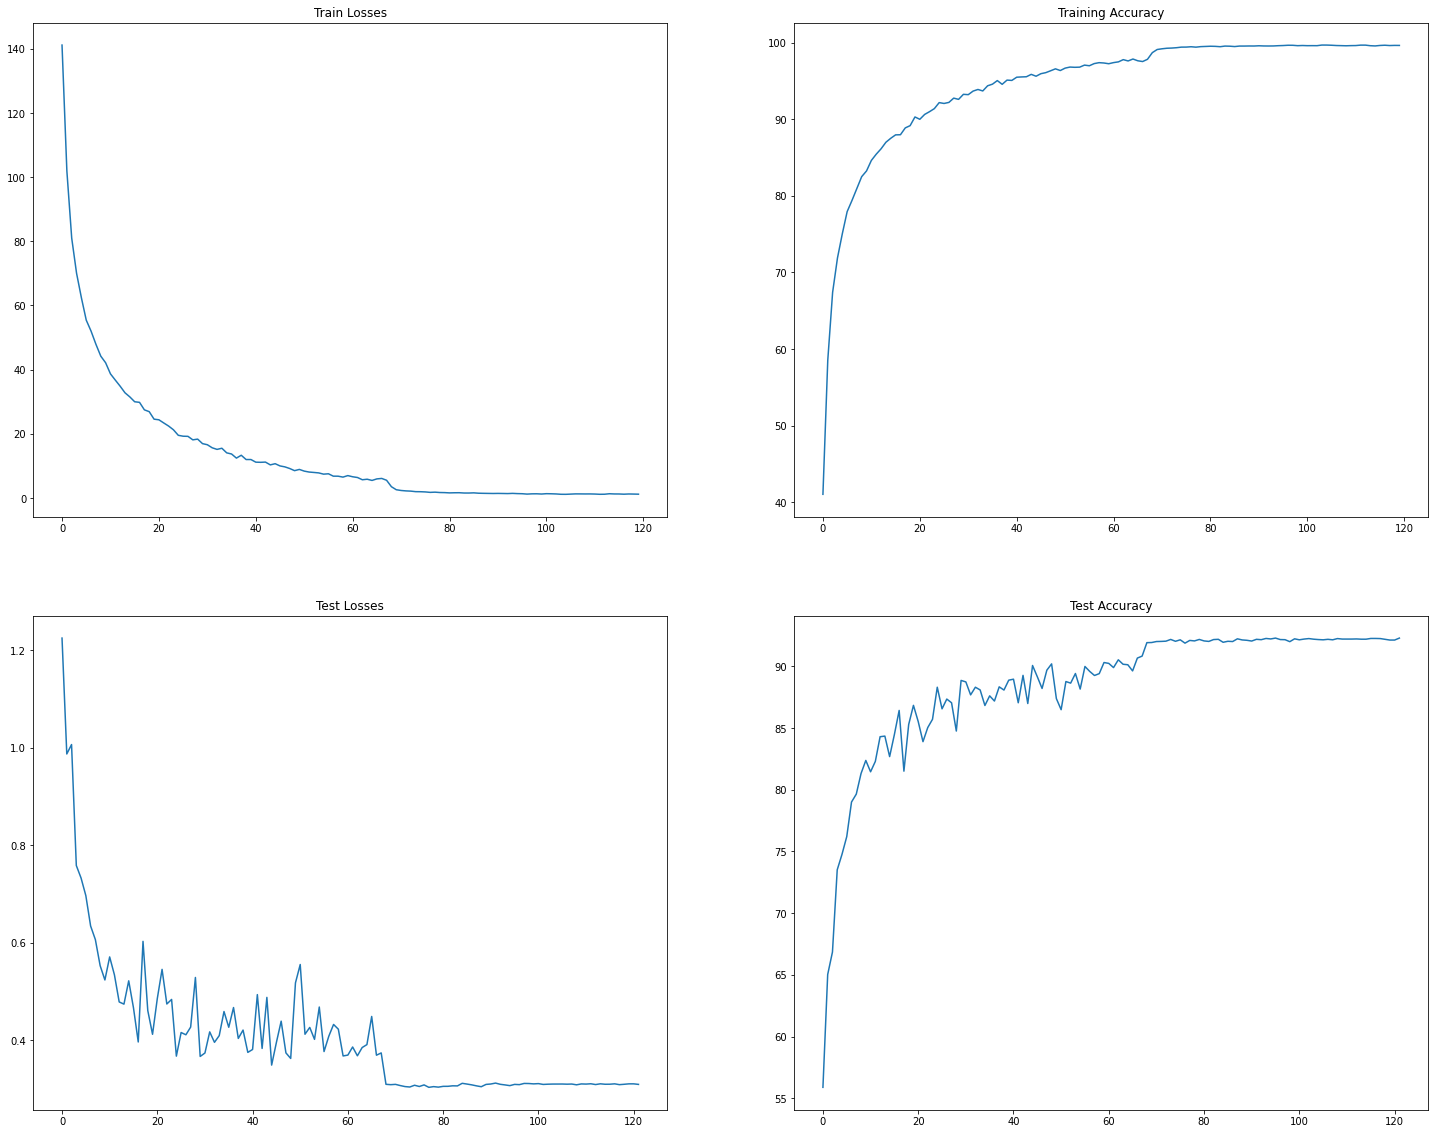

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)